# Tutorial 2-a: Automatic Feature Extraction/Engineering

---

### Introduction

In this notebook, we will extract/engineer features using a deep learning method called autoencoder.
The input and the output of this method will be the galaxy images. An autoencoder is an artificial neural network with a symmetric structure which is trained to reconstruct its input onto the output layer. The output of the first half of the network represents an encoding of the input data. ([source](https://arxiv.org/abs/2206.06165)).

First we import some libraries:

In [1]:
import matplotlib.pyplot as plt # for plotting data/graphs
import numpy as np # For handling N-DIMENSIONAL ARRAYS

import tensorflow as tf #An end-to-end machine learning platform, focusing on training deep learning models
from tensorflow.keras import layers, losses # Implementation of the Keras API, the high-level API of TensorFlow.
from tensorflow.keras.models import Model

# https://www.tensorflow.org/api_docs/python/tf/keras



2022-11-06 13:58:52.913852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 13:58:55.102985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-06 13:58:55.103071: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-06 13:58:55.296654: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-06 13:59:20.347277: W tensorflow/stream_executor/pla

---

### Reading in data

In [2]:
from galaxy_mnist import GalaxyMNISTHighrez

dataset_train = GalaxyMNISTHighrez(
    root='data_import/data',
    download=True,
    train=True  # by default, or False for canonical test set
)
# for the testing data
dataset_test = GalaxyMNISTHighrez(
    root='data_import/data',
    download=True,
    train=False  # by default, or False for canonical test set
)

In [3]:
images_train = dataset_train.data
images_test = dataset_test.data



In [4]:
labels_train = dataset_train.targets
labels_test = dataset_test.targets

In [5]:
class0_tr = np.where (np.array(labels_train) == 0 )
class1_tr = np.where (np.array(labels_train) == 1 )
class2_tr = np.where (np.array(labels_train) == 2 )
class3_tr = np.where (np.array(labels_train) == 3 )
#---
class0_te = np.where (np.array(labels_test) == 0 )
class1_te = np.where (np.array(labels_test) == 1 )
class2_te = np.where (np.array(labels_test) == 2 )
class3_te = np.where (np.array(labels_test) == 3 )

### Pre-processing 

In [6]:
from source.pre import pre_processing #  A predefined function to pre-process the data as we did in tutorial 1

In [7]:
# pre-processing(data, size) function takes two arguments
# 1. data: the data to be processed
# 2. The size for which the data needs to be reduced.
images_trainPre = pre_processing(images_train, 56)
images_testPre = pre_processing(images_test, 56)

In [8]:
images_trainPre.shape

(8000, 56, 56)

Displaying images after pre-processing

label: smooth_round


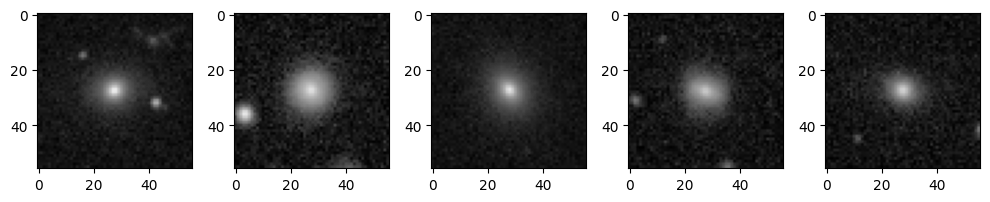

label: smooth_cigar


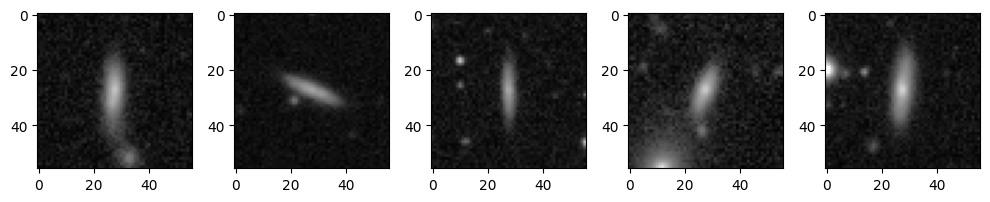

label: edge_on_disk


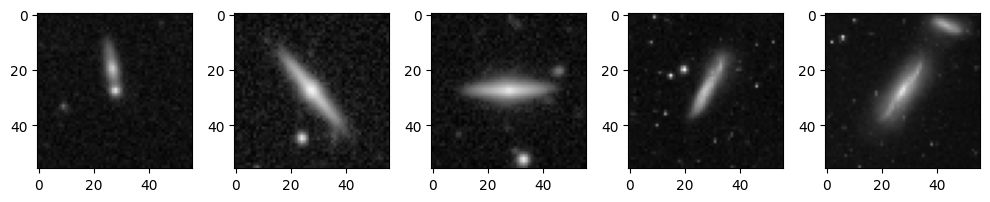

label: unbarred_spiral


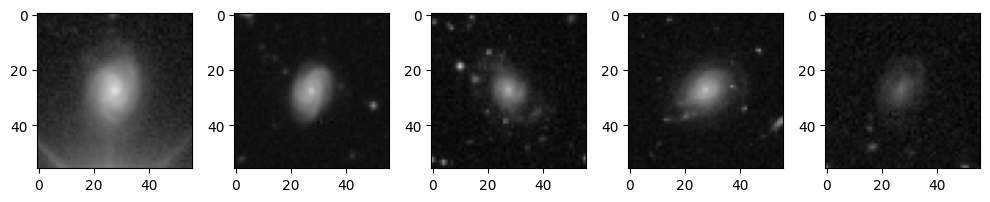

In [9]:
rows = 1
columns = 5
for classArr in [ [class0_tr,0], [class1_tr,1], [class2_tr,2], [class3_tr,3]]:
    fig = plt.figure(figsize=(10, 10))
    for i in range (5):
        train_image = images_trainPre[classArr[0][0][i]]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(train_image*255,cmap='gray', vmin=0, vmax=255 )
    print("label: "+str(GalaxyMNISTHighrez.classes[classArr[1]]))
    plt.tight_layout()
    plt.show()  

---

## Shallow Autoencoder

Now we will train the autoencoder nural network on the data that we pre-processed. The original code can be found [here](https://www.tensorflow.org/tutorials/generative/autoencoder).

In [10]:
latent_dim = 64 # the number of features to be encoded, this can change 
num, length, width  = images_trainPre.shape
# need to document how excatly it works

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(length*width, activation='sigmoid'),
      layers.Reshape((length, width))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

shallow_model = Autoencoder(latent_dim)

2022-11-06 14:00:41.723230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-06 14:00:41.723278: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-06 14:00:41.723301: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-015): /proc/driver/nvidia/version does not exist
2022-11-06 14:00:41.723716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
shallow_model.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=2)

`EarlyStopping()` has a few options and by default:
 - `monitor='val_loss'`: to use validation loss as performance measure to terminate the training.
- `patience=0`: is the number of epochs with no improvement. The value 0 means the training is terminated as soon as the performance measure gets worse from one epoch to the next.

In [13]:
shallow_model.fit(np.array(images_trainPre), np.array(images_trainPre),
                epochs=50,
                shuffle=True,
                validation_data=(np.array(images_trainPre), np.array(images_trainPre)), callbacks=[early_stopping])

Epoch 1/50
250/250 [==============================] - 2s 5ms/step - loss: 0.0120 - val_loss: 0.0049
Epoch 2/50
250/250 [==============================] - 1s 4ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 3/50
250/250 [==============================] - 1s 4ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 4/50
250/250 [==============================] - 1s 4ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 5/50
250/250 [==============================] - 1s 4ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 6/50
250/250 [==============================] - 1s 4ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 7/50
250/250 [==============================] - 1s 4ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 8/50
250/250 [==============================] - 1s 4ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 9/50
250/250 [==============================] - 1s 4ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/50
250/250 [==============================] - 1s 4ms/step - loss: 0.0025 - val_loss: 0.0026

You can notice that runing this code is quite fast, this is becuase the model is too shallow.

In [14]:
shallow_model.save("/users/hussein/work/galaxy-cluster/shallowModel_save") # saving the model


INFO:tensorflow:Assets written to: /users/hussein/work/galaxy-cluster/shallowModel_save/assets


In [15]:
encoded_imgs = shallow_model.encoder(images_testPre).numpy()
decoded_imgs = shallow_model.decoder(encoded_imgs).numpy()

In [16]:
print(decoded_imgs.shape)

(2000, 56, 56)


Origina: smooth_round


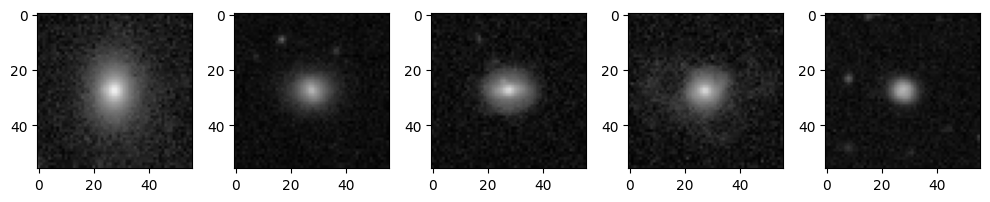

reconstructed: smooth_round


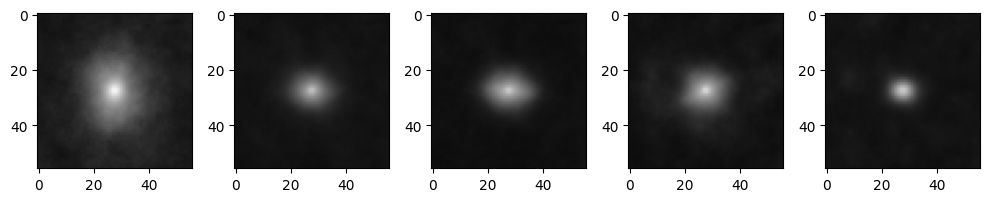

                       ______________________________________________________________________________     
Origina: smooth_cigar


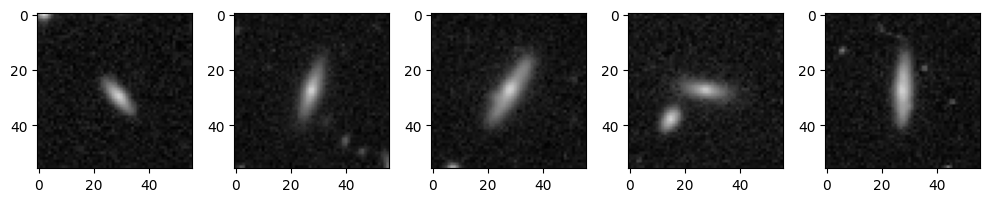

reconstructed: smooth_cigar


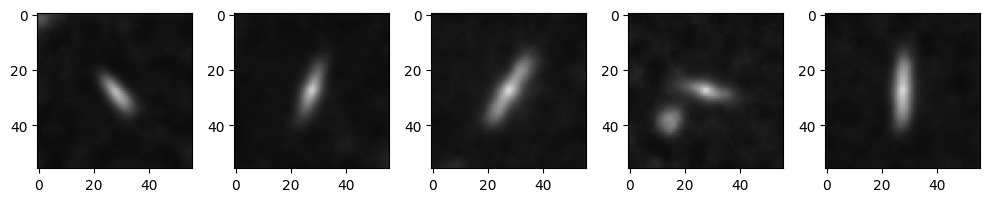

                       ______________________________________________________________________________     
Origina: edge_on_disk


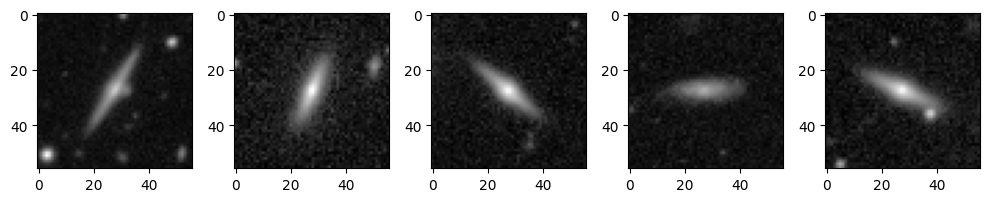

reconstructed: edge_on_disk


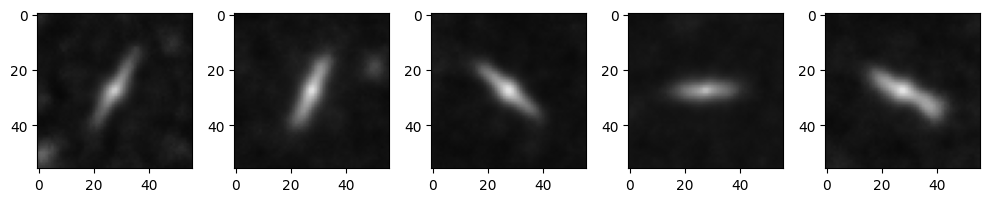

                       ______________________________________________________________________________     
Origina: unbarred_spiral


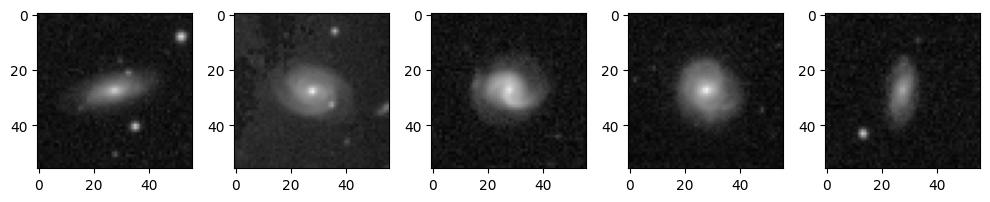

reconstructed: unbarred_spiral


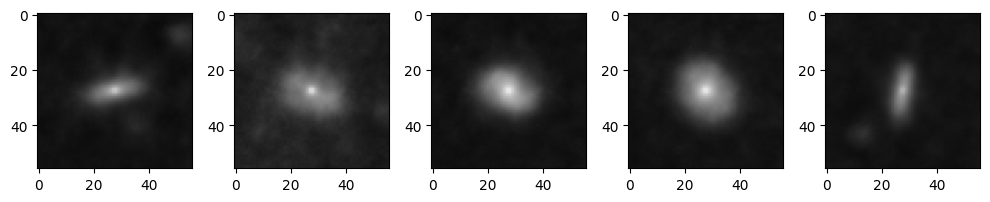

                       ______________________________________________________________________________     


In [17]:
for classArr in [ [class0_te,0], [class1_te,1], [class2_te,2], [class3_te,3]]:
    fig = plt.figure(figsize=(10, 10))
    for i in range (5):
        original_image = images_testPre[classArr[0][0][i]]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(original_image*255,cmap='gray', vmin=0, vmax=255 )
    print("Original: "+str(GalaxyMNISTHighrez.classes[classArr[1]]))
    plt.tight_layout()
    plt.show()
    
    fig = plt.figure(figsize=(10, 10))
    for i in range (5):
        dec_image = decoded_imgs[classArr[0][0][i]]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(dec_image*255,cmap='gray', vmin=0, vmax=255 )
    print("reconstructed: "+str(GalaxyMNISTHighrez.classes[classArr[1]]))
    plt.tight_layout()
    plt.show()
    
    print("                       ______________________________________________________________________________     ")

**Exercise 1:** Which classes do you think will be confused with the others?

In [50]:
### -- Answer here --


---

### Deep convolutional autoencoder

A convolutional autoencoder makes use of convolutional neural network mechanisms to reduce and engineer the images. Now let us try a more complicated model and notice the difference, time and image quality

In [40]:
class GalaxyEncoder(Model):
    def __init__(self):
        super(GalaxyEncoder, self).__init__()
        self.encoder = tf.keras.Sequential ([
            layers.InputLayer(input_shape=(56,56,1)),
            layers.Conv2D(16, (3,3), 1, padding="same", activation="relu"),
            layers.MaxPool2D((2,2), padding="same", strides=2),
            layers.Conv2D(8, (3,3), 1, padding="same", activation="relu"),
            layers.MaxPool2D((2,2), padding="same", strides=2),
            layers.Flatten()
        ])
        self.decoder = tf.keras.Sequential ([
            layers.InputLayer(input_shape=(1568)),
            layers.Reshape((14, 14, 8)),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(8, (3,3), 1, padding="same", activation="relu"),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(16, (3,3), 1, padding="same", activation="relu"),
            layers.Conv2D(1, (3,3), 1, padding="same", activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [41]:
deep_model = GalaxyEncoder()

In [42]:
deep_model.compile(optimizer='sgd', loss='mse')


In [43]:
deep_model.build((None, 56,56,1))
deep_model.summary()

Model: "galaxy_encoder_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 1568)              1320      
                                                                 
 sequential_11 (Sequential)  (None, 56, 56, 1)         1897      
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [44]:
early_stopping = EarlyStopping(patience=1)

In [45]:
deep_model.fit(np.array(images_trainPre), np.array(images_trainPre),
                epochs=50,
                shuffle=True,
                validation_data=(np.array(images_trainPre), np.array(images_trainPre)), callbacks=[early_stopping])
# start with the 2nd tut instead of waiting

Epoch 1/50
250/250 [==============================] - 16s 64ms/step - loss: 0.0567 - val_loss: 0.0146
Epoch 2/50
250/250 [==============================] - 16s 63ms/step - loss: 0.0136 - val_loss: 0.0131
Epoch 3/50
250/250 [==============================] - 15s 61ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 4/50
250/250 [==============================] - 16s 62ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 5/50
250/250 [==============================] - 16s 63ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 6/50
250/250 [==============================] - 16s 64ms/step - loss: 0.0100 - val_loss: 0.0093
Epoch 7/50
250/250 [==============================] - 16s 65ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 8/50
250/250 [==============================] - 16s 63ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 9/50
250/250 [==============================] - 16s 62ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 10/50
250/250 [==============================] - 16s 64ms/step - loss: 0.003

**Exercise 2:** Save the deep model for later use

In [46]:
### -- Code here --


In [47]:
encoded_imgs = deep_model.encoder(images_testPre).numpy()
decoded_imgs = deep_model.decoder(encoded_imgs).numpy()

Origina: smooth_round


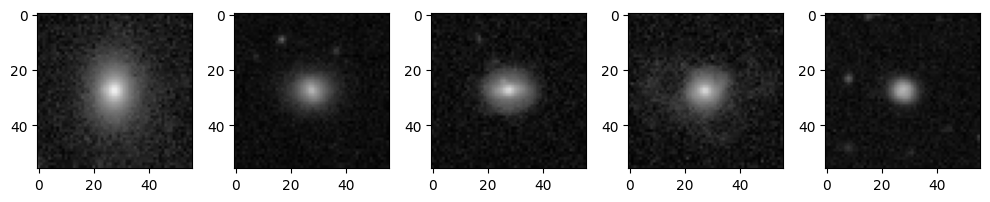

reconstructed: smooth_round


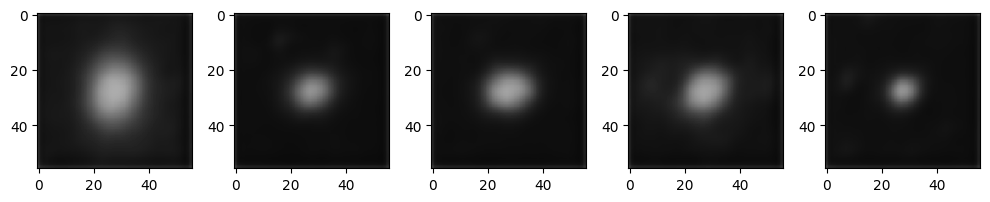

                       ______________________________________________________________________________     
Origina: smooth_cigar


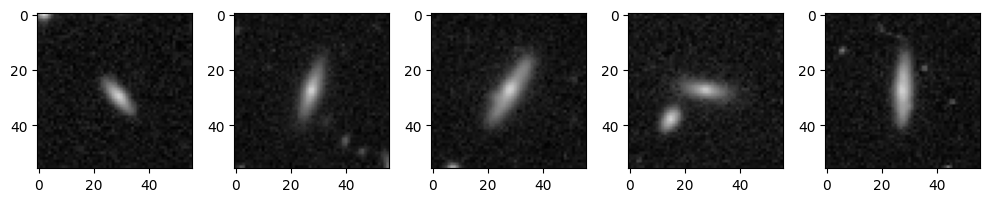

reconstructed: smooth_cigar


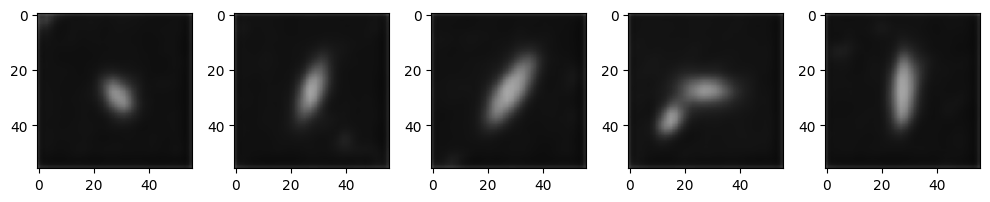

                       ______________________________________________________________________________     
Origina: edge_on_disk


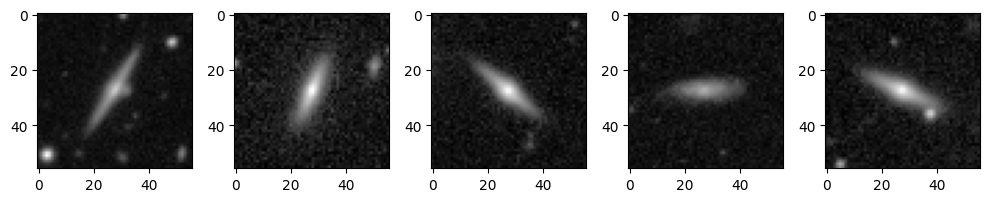

reconstructed: edge_on_disk


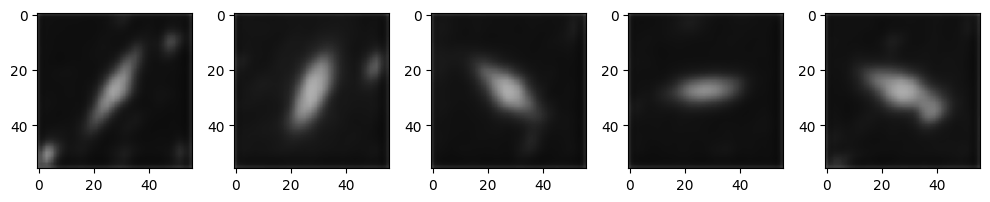

                       ______________________________________________________________________________     
Origina: unbarred_spiral


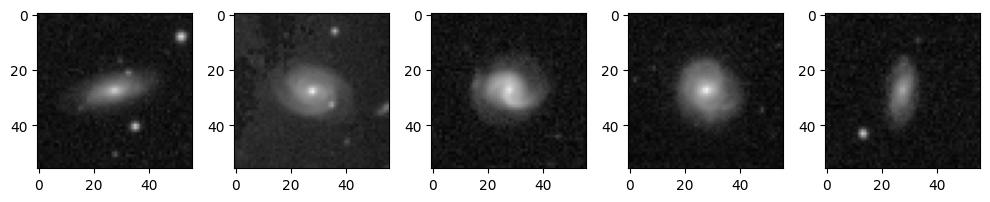

reconstructed: unbarred_spiral


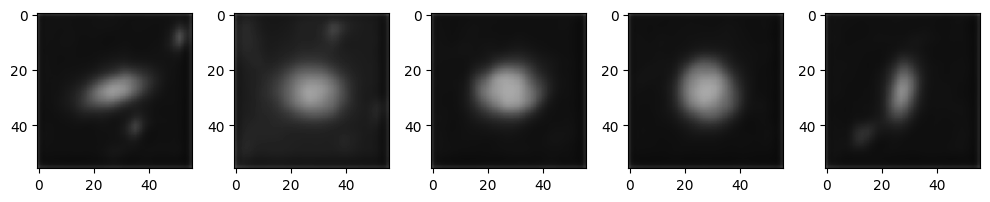

                       ______________________________________________________________________________     


In [48]:
for classArr in [ [class0_te,0], [class1_te,1], [class2_te,2], [class3_te,3]]:
    fig = plt.figure(figsize=(10, 10))
    for i in range (5):
        original_image = images_testPre[classArr[0][0][i]]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(original_image*255,cmap='gray', vmin=0, vmax=255 )
    print("Origina: "+str(GalaxyMNISTHighrez.classes[classArr[1]]))
    plt.tight_layout()
    plt.show()
    
    fig = plt.figure(figsize=(10, 10))
    for i in range (5):
        dec_image = decoded_imgs[classArr[0][0][i]]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(dec_image*255,cmap='gray', vmin=0, vmax=255 )
    print("reconstructed: "+str(GalaxyMNISTHighrez.classes[classArr[1]]))
    plt.tight_layout()
    plt.show()
    
    print("                       ______________________________________________________________________________     ")

**Exercise 3:** Visually how do the reconstructed images from the deep model compare to the shallow one?

In [51]:
### -- Answer here --


I think including the time in thier analysis will be very good.

---

#### **_Saving data for later use_**

We can save the data so that we can call it up again in subsequent notebooks

In [52]:
%store images_trainPre
%store images_testPre
%store labels_train
%store labels_test

Stored 'images_trainPre' (ndarray)
Stored 'images_testPre' (ndarray)
Stored 'labels_train' (Tensor)
Stored 'labels_test' (Tensor)
